# Experiments (Appendix)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from dataset import CompasDataset, CreditDataset, DiabetesDataset
from simulator import Simulator
from explainer import BaselineExplainer, LinucbExplainer, BwoucbExplainer, CgpucbExplainer

plt.rcParams["font.family"] = 'arial'
plt.rcParams['text.usetex'] = True
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown']
markers = ['o', 's', '^', 'v', '*', 'D']
fontsize = 12

In [2]:
def run_comparison(
    dataset, 
    methods=['ProtoAR', 'TAP', 'LinUCB', 'BwOUCB'],
    estimator=RandomForestClassifier(), 
    n_trials=5, 
    n_timeout=10,
    max_counterfactuals=200,
    cost_types=('norm', 'norm'),
    delay_type=0.2,
    improvement_noise=0.1,
    probability_noise=0.0,
    model_update=0,
    keys = ['cumulative_regret', 'mean_expected_reward', 'improvement', 'cost', 'time'],
    verbose=True,
):
    
    np.random.seed(0)
    simulator = Simulator(
        estimator, 
        dataset, 
        n_timeout=n_timeout,
        max_counterfactuals=max_counterfactuals,
        cost_type=cost_types[0], 
        delay_type=delay_type, 
        improvement_noise=improvement_noise, 
        probability_noise=probability_noise,
        model_update=model_update,
    )

    results = {}
    for method in methods:
        if method == 'ProtoAR':
            explainer = BaselineExplainer(cost_type=cost_types[1])
        elif method == 'TAP':
            explainer = BaselineExplainer(cost_type=cost_types[1], fit_verifier=True)
        elif method == 'LinUCB':
            explainer = LinucbExplainer(cost_type=cost_types[1])
        elif method == 'BwOUCB':
            explainer = BwoucbExplainer()
        elif method == 'CGPUCB':
            explainer = CgpucbExplainer()
            
        results[method] = {}
        for key in keys:
            results[method][key] = np.zeros((n_trials, simulator.n_rounds))

        for n_trial in tqdm(range(n_trials), disable=(not verbose)):
            warnings.simplefilter('ignore')
            result = simulator.run(explainer)
            warnings.resetwarnings()
            for key in keys:
                results[method][key][n_trial] = result[key]
    
    return results


def run_sensitivity_of_linucb(
    dataset, 
    alphas = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0],
    estimator=RandomForestClassifier(), 
    n_trials=5, 
    n_timeout=10,
    max_counterfactuals=200,
    cost_types=('norm', 'norm'),
    delay_type=0.2,
    improvement_noise=0.1,
    probability_noise=0.0,
    keys = ['cumulative_regret', 'mean_expected_reward', 'improvement', 'cost', 'time'],
    verbose=True,
):
    
    np.random.seed(0)
    simulator = Simulator(
        estimator, 
        dataset, 
        n_timeout=n_timeout,
        max_counterfactuals=max_counterfactuals,
        cost_type=cost_types[0], 
        delay_type=delay_type, 
        improvement_noise=improvement_noise, 
        probability_noise=probability_noise
    )

    results = {}
    for alpha in alphas:
        explainer = LinucbExplainer(cost_type=cost_types[1], alpha=alpha)
            
        results[alpha] = {}
        for key in keys:
            results[alpha][key] = np.zeros((n_trials, simulator.n_rounds))

        for n_trial in tqdm(range(n_trials), disable=(not verbose)):
            result = simulator.run(explainer)
            for key in keys:
                results[alpha][key][n_trial] = result[key]
    
    return results


def run_sensitivity_of_bwoucb(
    dataset, 
    n_estimators = [25, 50, 75, 100],
    estimator=RandomForestClassifier(), 
    n_trials=5, 
    n_timeout=10,
    max_counterfactuals=200,
    cost_types=('norm', 'norm'),
    delay_type=0.2,
    improvement_noise=0.1,
    probability_noise=0.0,
    keys = ['cumulative_regret', 'mean_expected_reward', 'improvement', 'cost', 'time'],
    verbose=True,
):
    
    np.random.seed(0)
    simulator = Simulator(
        estimator, 
        dataset, 
        n_timeout=n_timeout,
        max_counterfactuals=max_counterfactuals,
        cost_type=cost_types[0], 
        delay_type=delay_type, 
        improvement_noise=improvement_noise, 
        probability_noise=probability_noise
    )

    results = {}
    for n_estimator in n_estimators:
        explainer = BwoucbExplainer(n_estimators=n_estimator)
            
        results[n_estimator] = {}
        for key in keys:
            results[n_estimator][key] = np.zeros((n_trials, simulator.n_rounds))

        for n_trial in tqdm(range(n_trials), disable=(not verbose)):
            result = simulator.run(explainer)
            for key in keys:
                results[n_estimator][key][n_trial] = result[key]
    
    return results

In [3]:
def scatter_results(results, key1='improvement', key2='cost', key_=None, figsize=(12, 3)):
    fig = plt.figure(figsize=figsize)
    for j, dataset in enumerate(results.keys()):
        if key_ is not None:
            results_dataset = results[dataset][key_]
        else:
            results_dataset = results[dataset]
        methods = results_dataset.keys()
        plt.subplot(1, len(results.keys()), j+1)
        for i, method in enumerate(methods):
            x = results_dataset[method][key1]
            y = results_dataset[method][key2]
            plt.scatter(x.mean(axis=1), y.mean(axis=1), label=method, c=colors[i], s=75, marker=markers[i])
        plt.grid()
        plt.title(dataset, fontsize=fontsize)
        plt.xlabel('Average {}'.format(key1.replace('_', ' ').title()), fontsize=fontsize)
        plt.ylabel('Average {}'.format(key2.replace('_', ' ').title()), fontsize=fontsize)
        if j==0: plt.legend()
        plt.tight_layout()


def plot_results(results, key='mean_reward', key_=None, figsize=(12, 3)):
    fig = plt.figure(figsize=figsize)
    for j, dataset in enumerate(results.keys()):
        if key_ is not None:
            results_dataset = results[dataset][key_]
        else:
            results_dataset = results[dataset]
        methods = results_dataset.keys()
        plt.subplot(1, len(results.keys()), j+1)
        for i, method in enumerate(methods):
            y = results_dataset[method][key]
            x = np.arange(y.shape[1])
            plt.plot(x, y.mean(axis=0), label=method, c=colors[i])
        plt.grid()
        plt.title(dataset, fontsize=fontsize)
        plt.xlabel('Number of Rounds', fontsize=fontsize)
        if key == 'mean_expected_reward':
            plt.ylabel('Average MER', fontsize=fontsize)
        else:
            plt.ylabel('Average {}'.format(key.replace('_', ' ').title()), fontsize=fontsize)
        if j==0: plt.legend()
        plt.tight_layout()


def errorbar_result(results, key='mean_reward', xlabel='', line_method=[], figsize=(12, 2)): 
    fig = plt.figure(figsize=figsize)
    for j, dataset in enumerate(results.keys()):
        results_dataset = results[dataset]
        x = list(results_dataset.keys())
        methods = results_dataset[x[0]].keys()
        plt.subplot(1, len(results.keys()), j+1)
        for i, method in enumerate(methods):
            if key in ['mean_expected_reward', 'cumulative_regret', 'mean_reward']:
                y = np.array([results_dataset[param][method][key][:, -1] for param in x])
            else:
                y = np.array([results_dataset[param][method][key].mean(axis=1) for param in x])
            if method in line_method:
                plt.axhline(y[0].mean(), color=colors[i], label=method, linestyle='dashed') 
                plt.axhspan(y[0].mean()-y[0].std(), y[0].mean()+y[0].std(), facecolor=colors[i], alpha=0.25)
            else:
                plt.errorbar(x, y.mean(axis=1), y.std(axis=1), marker=markers[i], c=colors[i], markersize=5, capsize=5, label=method)
        plt.grid()
        plt.title(dataset, fontsize=fontsize)
        plt.xlabel(xlabel, fontsize=fontsize)
        if key == 'mean_expected_reward':
            plt.ylabel('Average MER', fontsize=fontsize)
        else:
            plt.ylabel('Average {}'.format(key.replace('_', ' ').title()), fontsize=fontsize)
        if j==0: plt.legend()
        plt.tight_layout()
    
    
def latex_result(results, key='time', key_=None):
    print('\\toprule')
    x = list(results.keys())
    if key_ is not None:
        methods = results[x[0]][key_].keys()
    else:
        methods = results[x[0]].keys()
    s = '\\textbf{Dataset} '
    for method in methods:
        s += '& \\textbf{' + method + '} '
    s += '\\\\'
    print(s)
    print('\\midrule')
    
    for j, dataset in enumerate(results.keys()):
        if key_ is not None:
            results_dataset = results[dataset][key_]
        else:
            results_dataset = results[dataset]
        s = '{} '.format(dataset)
        for method in methods:
            score = results_dataset[method][key]
            s += '& ${} \pm {}$ '.format(score.mean().round(6), score.std().round(4))
        s += '\\\\'
        print(s)
    print('\\bottomrule')
    print()

# 01. Baseline Comparison

In [4]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for probability_noise in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]:
        results[dataset.name][probability_noise] = run_comparison(dataset, n_trials=10, probability_noise=probability_noise)

with open('./res/appendix/01_comparison_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)

results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for probability_noise in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]:
        results[dataset.name][probability_noise] = run_comparison(dataset, estimator=MLPClassifier(max_iter=5000), n_trials=10, probability_noise=probability_noise)

with open('./res/appendix/01_comparison_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 10/10 [03:15<00:00, 19.50s/it]


Diabetes


100%|██████████| 10/10 [03:09<00:00, 18.94s/it]


COMPAS


100%|██████████| 10/10 [02:59<00:00, 17.90s/it]


Credit


100%|██████████| 10/10 [03:41<00:00, 22.12s/it]


Diabetes


100%|██████████| 10/10 [03:15<00:00, 19.51s/it]


COMPAS


100%|██████████| 10/10 [03:01<00:00, 18.18s/it]


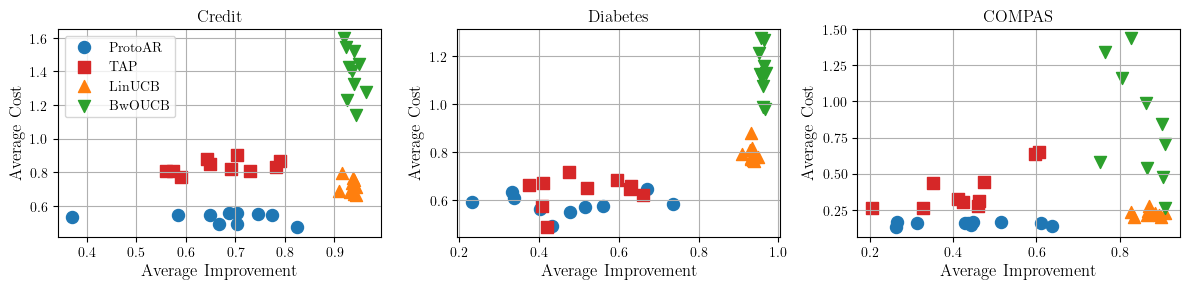

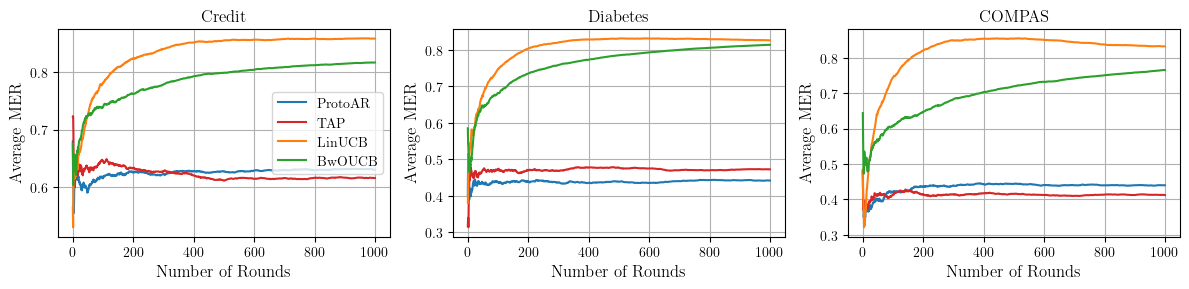

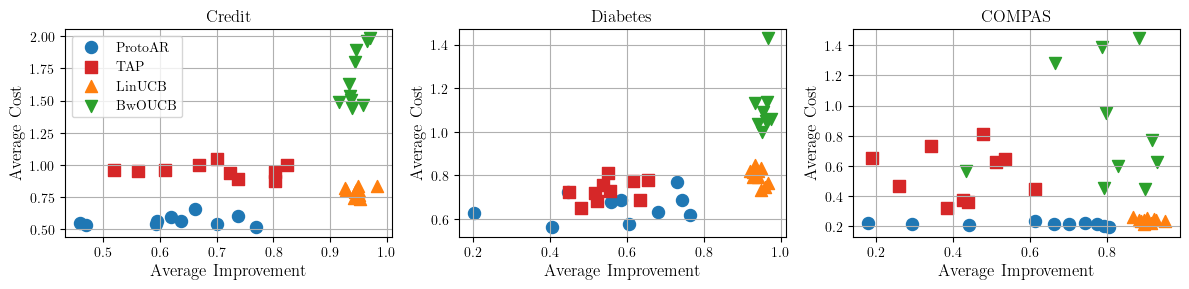

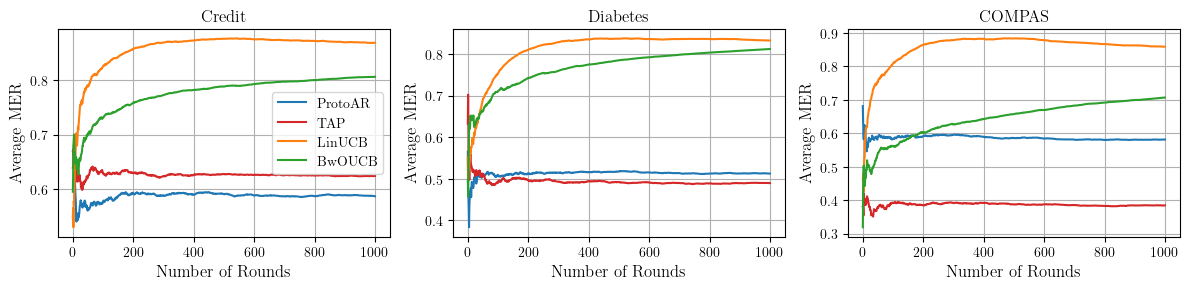

In [5]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/01_comparison_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost', key_=0.0)
    plt.savefig('./fig/appendix/01_comparison_without_noise_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/01_comparison_without_noise_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward', key_=0.0)
    plt.savefig('./fig/appendix/01_comparison_without_noise_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/01_comparison_without_noise_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

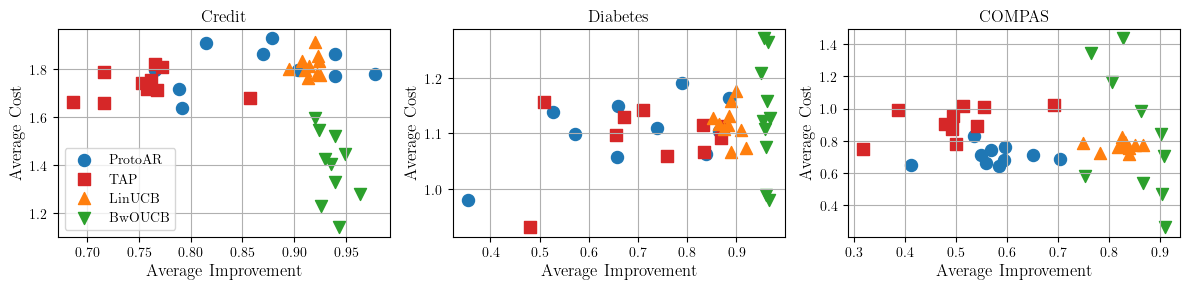

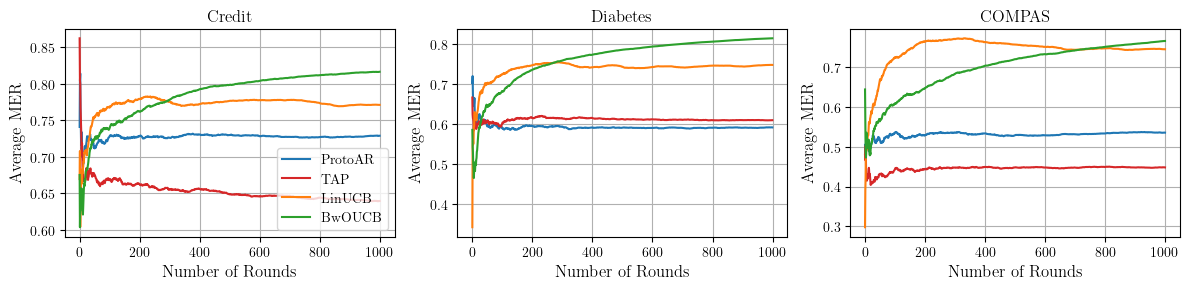

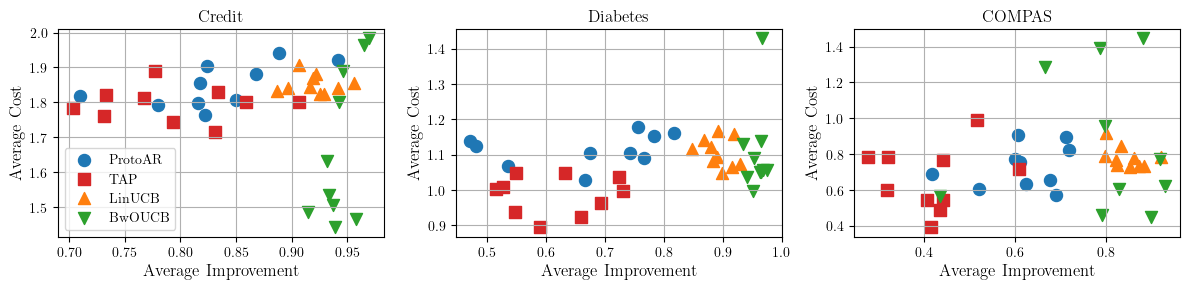

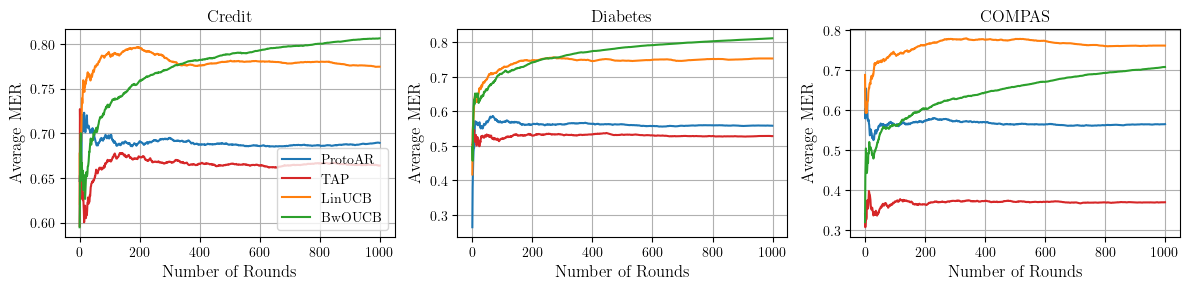

In [6]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/01_comparison_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost', key_=0.25)
    plt.savefig('./fig/appendix/01_comparison_with_noise_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/01_comparison_with_noise_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward', key_=0.25)
    plt.savefig('./fig/appendix/01_comparison_with_noise_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/01_comparison_with_noise_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

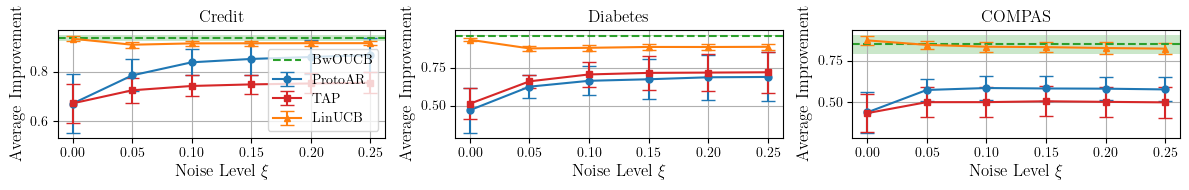

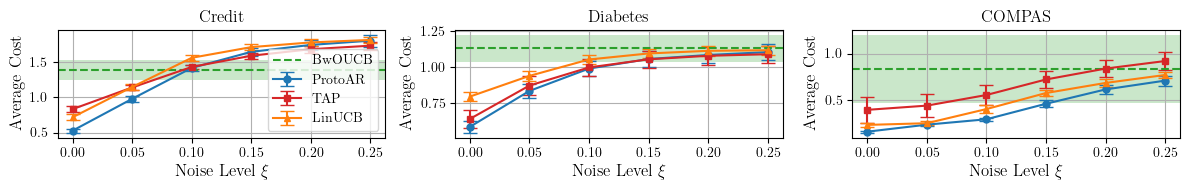

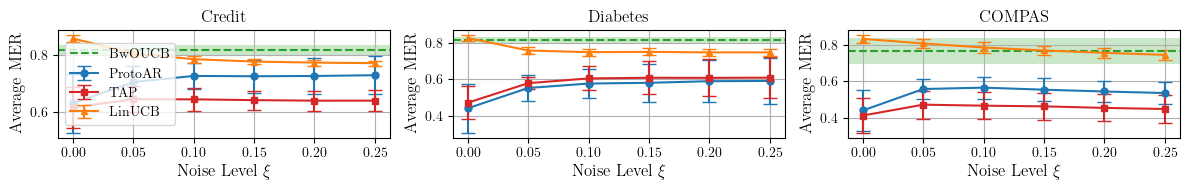

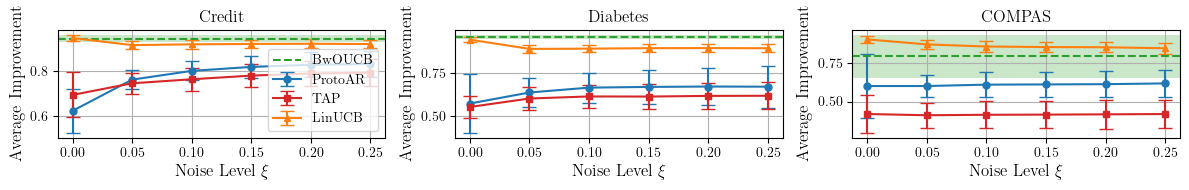

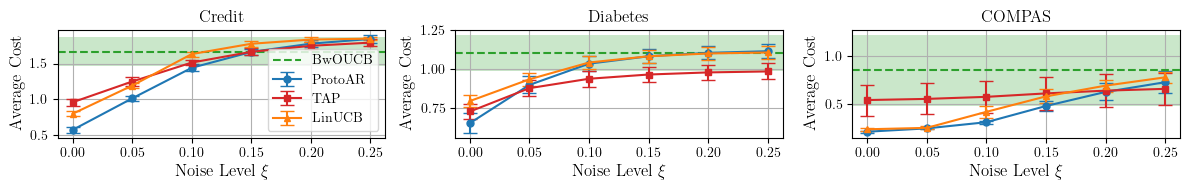

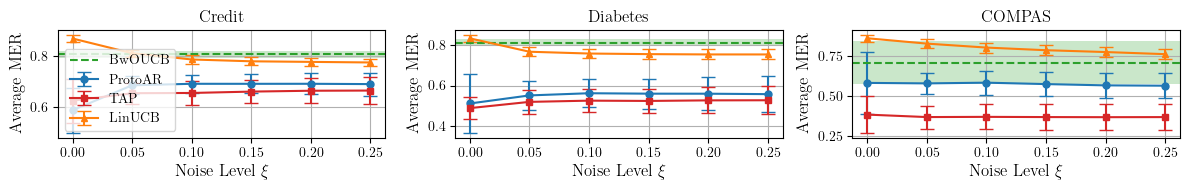

In [7]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/01_comparison_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    errorbar_result(results, key='improvement', xlabel=r'Noise Level $\xi$', line_method=['BwOUCB'])
    plt.savefig('./fig/appendix/01_sensitivity_of_noise_improvement_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/01_sensitivity_of_noise_improvement_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='cost', xlabel=r'Noise Level $\xi$', line_method=['BwOUCB'])
    plt.savefig('./fig/appendix/01_sensitivity_of_noise_cost_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/01_sensitivity_of_noise_cost_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='mean_expected_reward', xlabel=r'Noise Level $\xi$', line_method=['BwOUCB'])
    plt.savefig('./fig/appendix/01_sensitivity_of_noise_reward_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/01_sensitivity_of_noise_reward_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)


## 02. Cost-Mixture Scenario

In [8]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, n_trials=10, cost_types=('mps', 'norm'))

with open('./res/appendix/02_costmix_without_noise_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, n_trials=10, cost_types=('mps', 'norm'), probability_noise=0.25)

with open('./res/appendix/02_costmix_with_noise_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, estimator=MLPClassifier(max_iter=5000), n_trials=10, cost_types=('mps', 'norm'))

with open('./res/appendix/02_costmix_without_noise_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, estimator=MLPClassifier(max_iter=5000), n_trials=10, cost_types=('mps', 'norm'), probability_noise=0.25)

with open('./res/appendix/02_costmix_with_noise_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 10/10 [03:26<00:00, 20.61s/it]


Diabetes


100%|██████████| 10/10 [03:10<00:00, 19.06s/it]


COMPAS


100%|██████████| 10/10 [02:58<00:00, 17.87s/it]


Credit


100%|██████████| 10/10 [03:26<00:00, 20.64s/it]


Diabetes


100%|██████████| 10/10 [03:10<00:00, 19.05s/it]


COMPAS


100%|██████████| 10/10 [02:54<00:00, 17.44s/it]


Credit


100%|██████████| 10/10 [03:54<00:00, 23.45s/it]


Diabetes


100%|██████████| 10/10 [03:11<00:00, 19.12s/it]


COMPAS


100%|██████████| 10/10 [02:56<00:00, 17.63s/it]


Credit


100%|██████████| 10/10 [04:01<00:00, 24.18s/it]


Diabetes


100%|██████████| 10/10 [03:12<00:00, 19.30s/it]


COMPAS


100%|██████████| 10/10 [02:55<00:00, 17.54s/it]


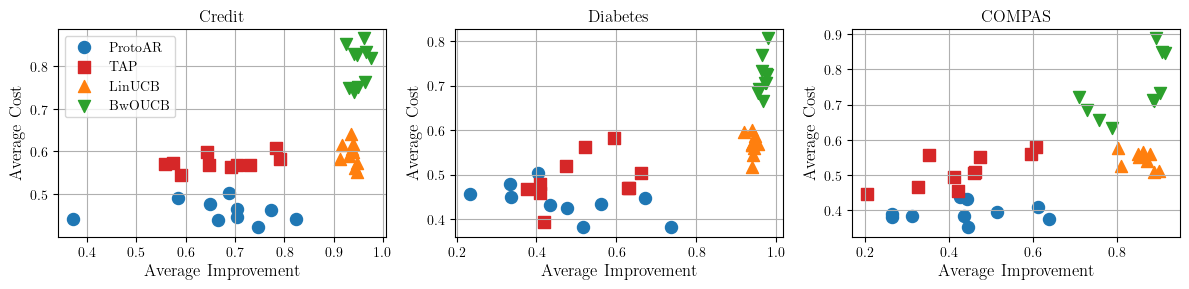

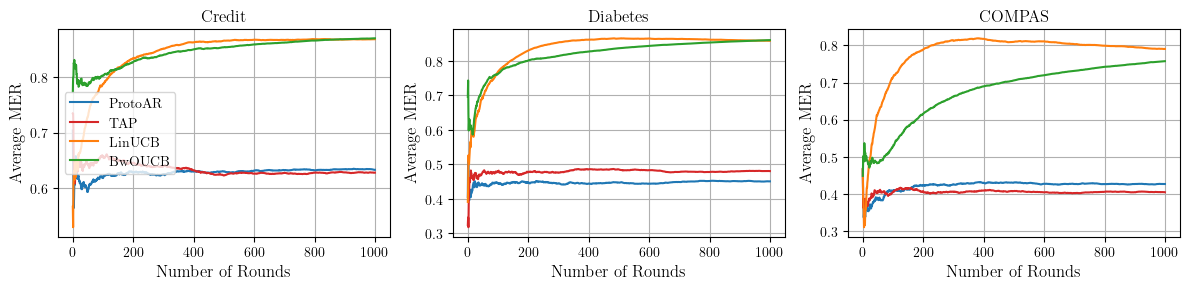

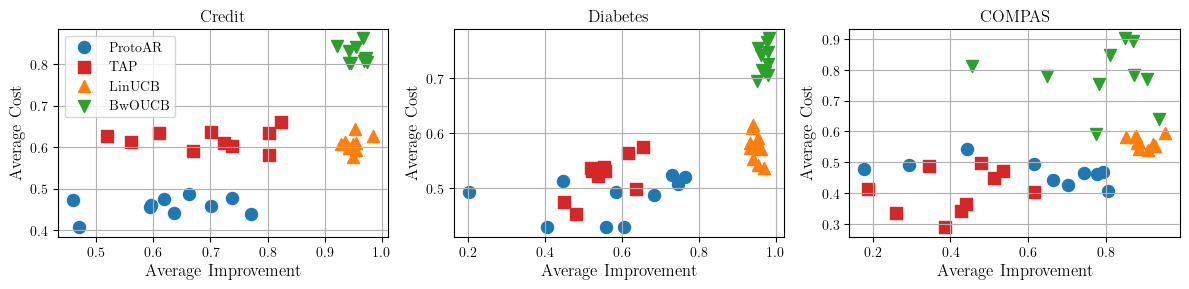

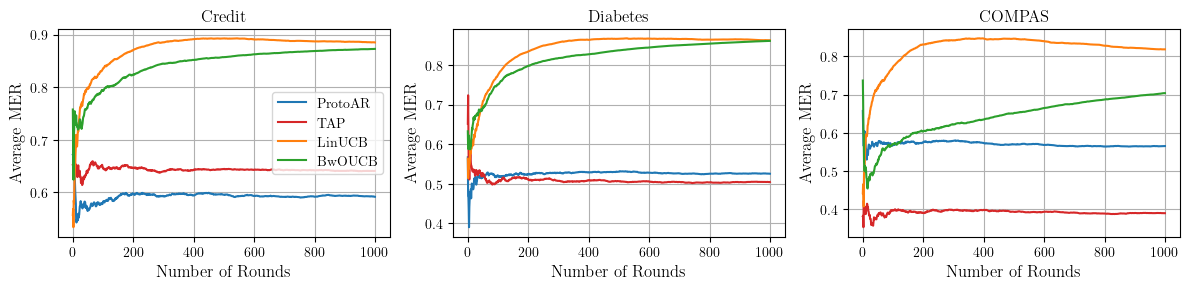

In [9]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/02_costmix_without_noise_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost')
    plt.savefig('./fig/appendix/02_costmix_without_noise_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/02_costmix_without_noise_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward')
    plt.savefig('./fig/appendix/02_costmix_without_noise_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/02_costmix_without_noise_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

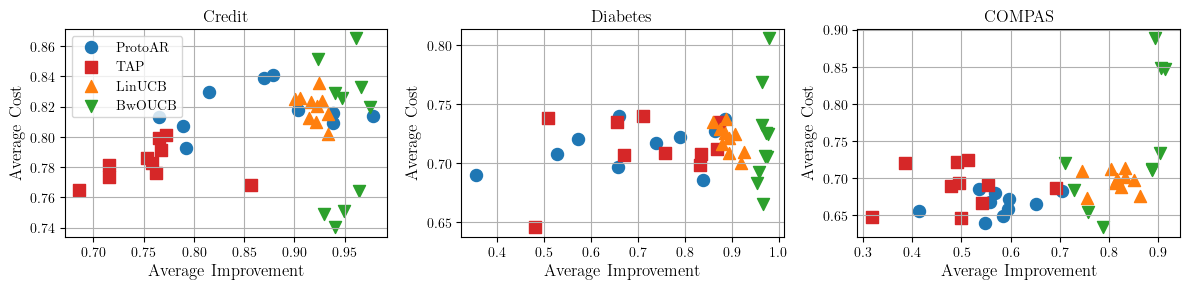

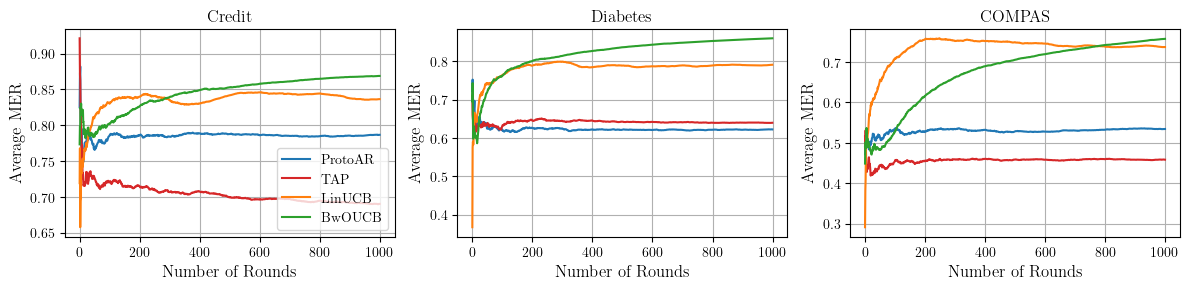

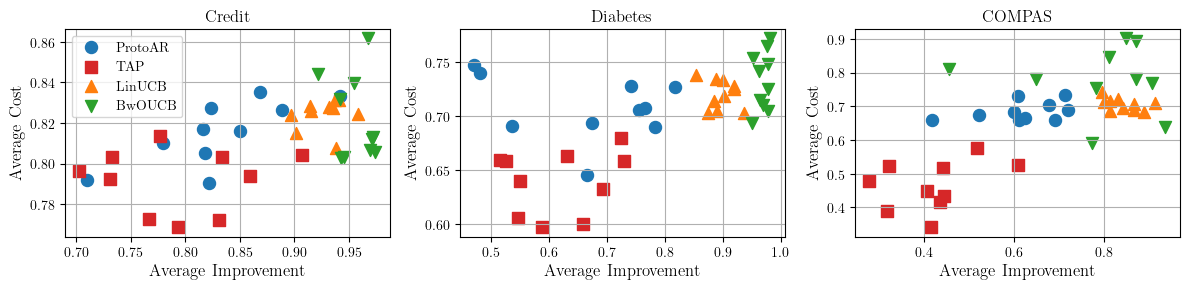

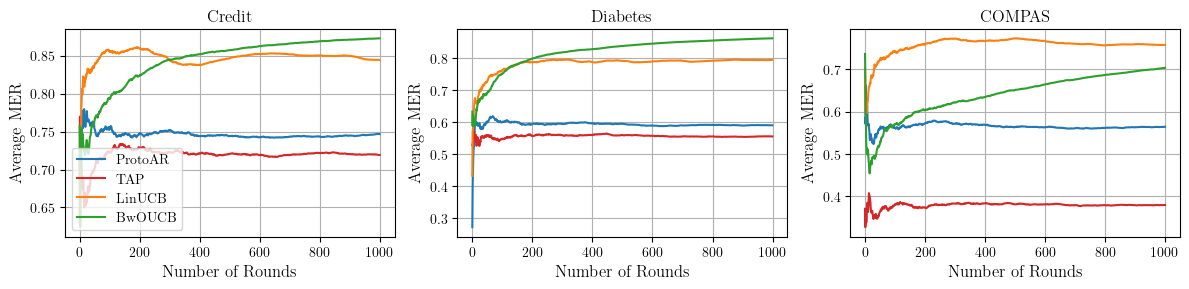

In [10]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/02_costmix_with_noise_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost')
    plt.savefig('./fig/appendix/02_costmix_with_noise_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/02_costmix_with_noise_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward')
    plt.savefig('./fig/appendix/02_costmix_with_noise_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/02_costmix_with_noise_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

## 03. Adaptive-Delay Scenario

In [11]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, n_trials=10, delay_type='adaptive')

with open('./res/appendix/03_delay_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, estimator=MLPClassifier(max_iter=5000), n_trials=10, delay_type='adaptive')

with open('./res/appendix/03_delay_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 10/10 [02:53<00:00, 17.35s/it]


Diabetes


100%|██████████| 10/10 [02:45<00:00, 16.57s/it]


COMPAS


100%|██████████| 10/10 [02:34<00:00, 15.44s/it]


Credit


100%|██████████| 10/10 [03:40<00:00, 22.09s/it]


Diabetes


100%|██████████| 10/10 [02:58<00:00, 17.82s/it]


COMPAS


100%|██████████| 10/10 [02:42<00:00, 16.26s/it]


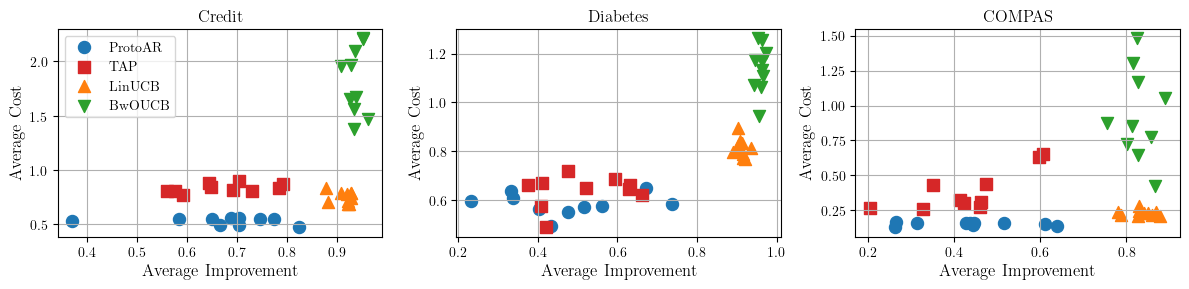

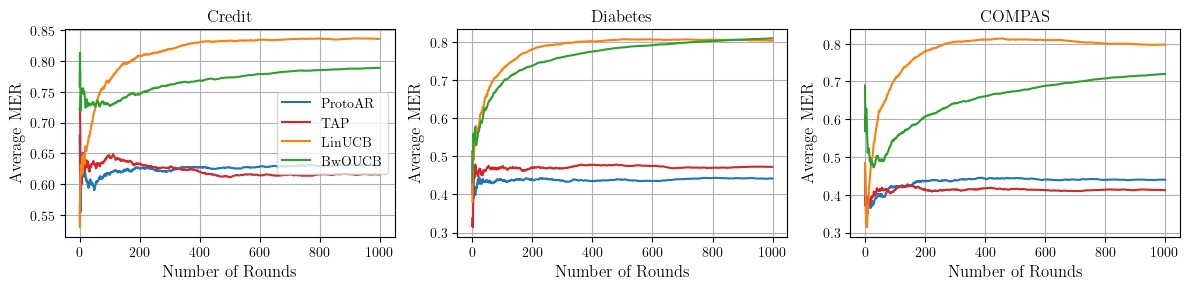

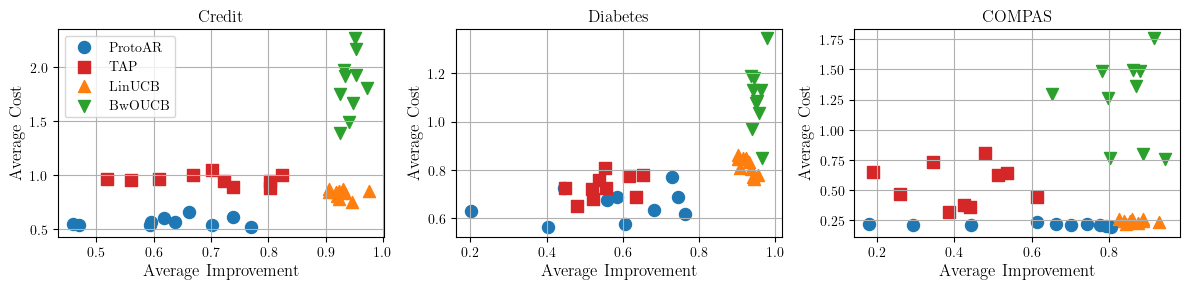

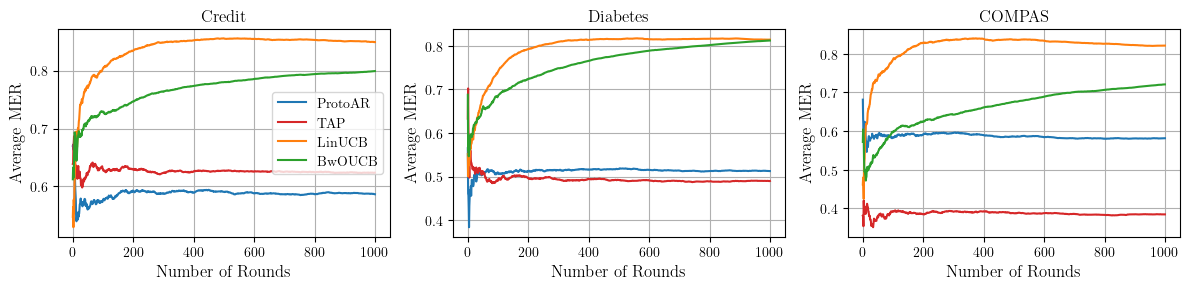

In [12]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/03_delay_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost')
    plt.savefig('./fig/appendix/03_delay_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/03_delay_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward')
    plt.savefig('./fig/appendix/03_delay_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/03_delay_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

## 04. Sensitivity Analysis (Number of Recourse Instances)

In [13]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for max_counterfactuals in [20, 40, 60, 80, 100]:
        results[dataset.name][max_counterfactuals] = run_comparison(dataset, max_counterfactuals=max_counterfactuals)

with open('./res/appendix/04_counterfactuals_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for max_counterfactuals in [20, 40, 60, 80, 100]:
        results[dataset.name][max_counterfactuals] = run_comparison(dataset, estimator=MLPClassifier(max_iter=5000), max_counterfactuals=max_counterfactuals)

with open('./res/appendix/04_counterfactuals_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 5/5 [01:35<00:00, 19.09s/it]


Diabetes


100%|██████████| 5/5 [01:31<00:00, 18.31s/it]


COMPAS


100%|██████████| 5/5 [01:23<00:00, 16.78s/it]


Credit


100%|██████████| 5/5 [01:59<00:00, 23.87s/it]


Diabetes


100%|██████████| 5/5 [01:38<00:00, 19.75s/it]


COMPAS


100%|██████████| 5/5 [01:41<00:00, 20.24s/it]


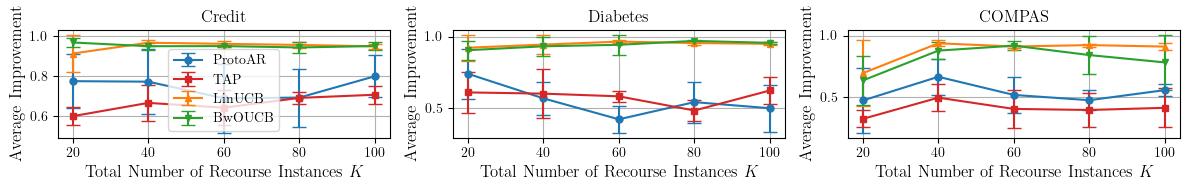

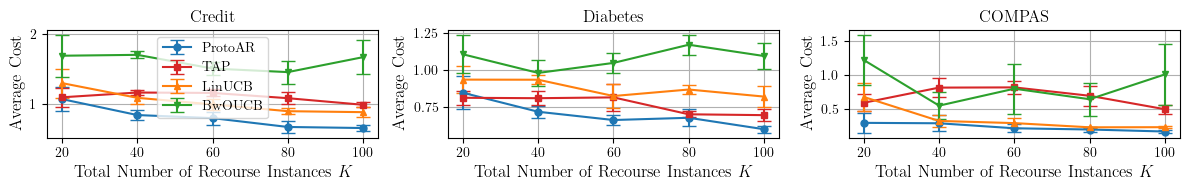

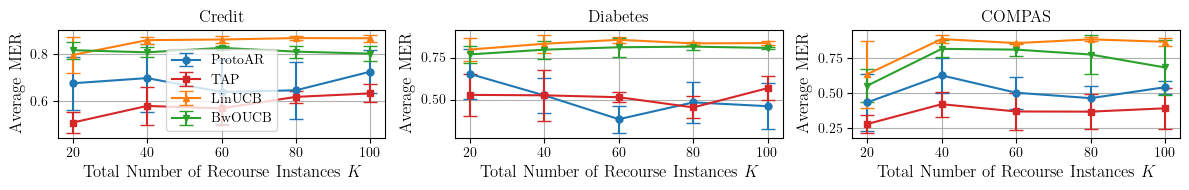

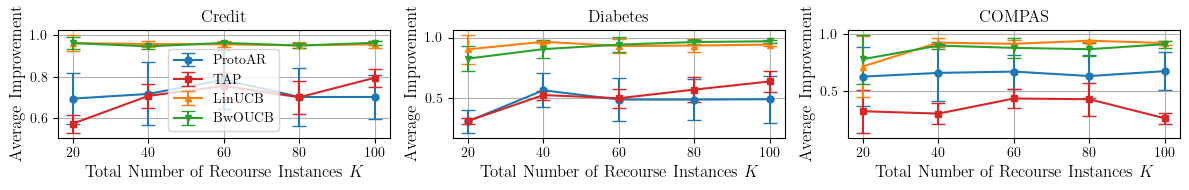

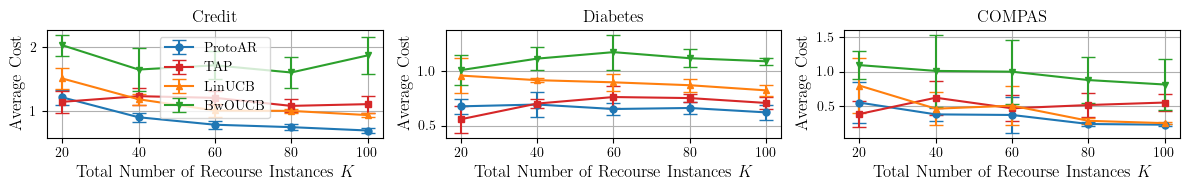

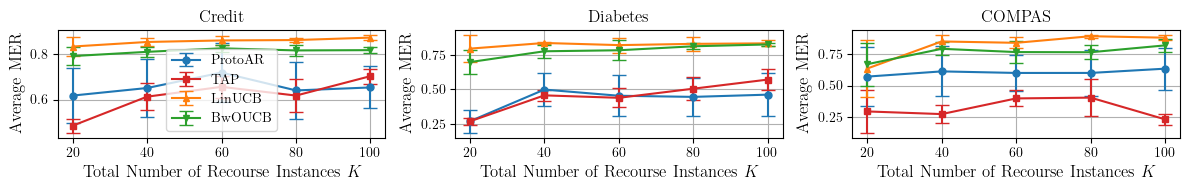

In [14]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/04_counterfactuals_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    errorbar_result(results, key='improvement', xlabel=r'Total Number of Recourse Instances $K$')
    plt.savefig('./fig/appendix/04_counterfactuals_improvement_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/04_counterfactuals_improvement_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='cost', xlabel=r'Total Number of Recourse Instances $K$')
    plt.savefig('./fig/appendix/04_counterfactuals_cost_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/04_counterfactuals_cost_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='mean_expected_reward', xlabel=r'Total Number of Recourse Instances $K$')
    plt.savefig('./fig/appendix/04_counterfactuals_reward_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/04_counterfactuals_reward_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)


## 05. Sensitivity Analysis (Window Parameter)

In [15]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for n_timeout in [4, 8, 12, 16, 20]:
        results[dataset.name][n_timeout] = run_comparison(dataset, n_timeout=n_timeout)

with open('./res/appendix/05_timeout_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for n_timeout in [4, 8, 12, 16, 20]:
        results[dataset.name][n_timeout] = run_comparison(dataset, estimator=MLPClassifier(max_iter=5000), n_timeout=n_timeout)

with open('./res/appendix/05_timeout_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 5/5 [01:44<00:00, 20.98s/it]


Diabetes


100%|██████████| 5/5 [01:37<00:00, 19.43s/it]


COMPAS


100%|██████████| 5/5 [01:35<00:00, 19.01s/it]


Credit


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]


Diabetes


100%|██████████| 5/5 [01:41<00:00, 20.31s/it]


COMPAS


100%|██████████| 5/5 [01:43<00:00, 20.69s/it]


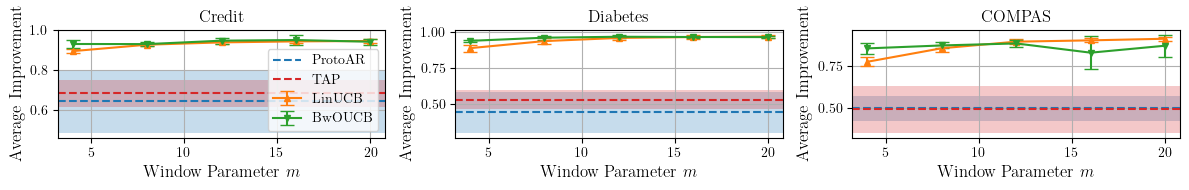

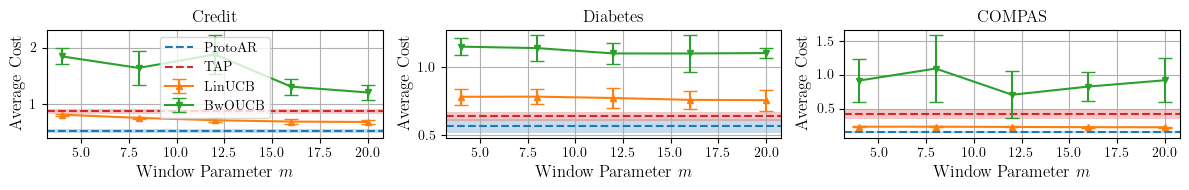

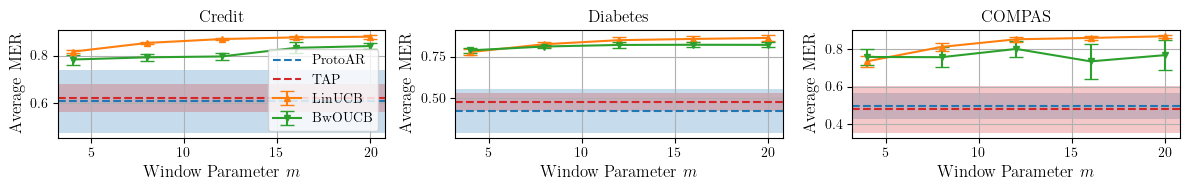

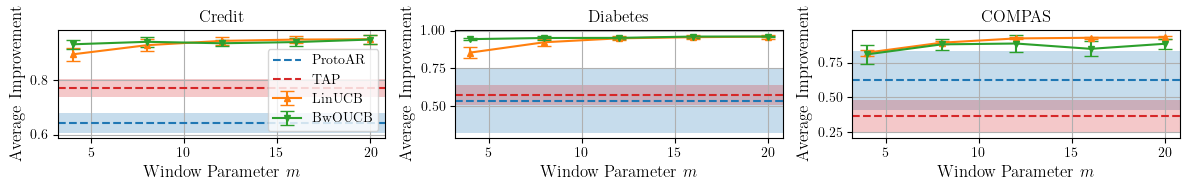

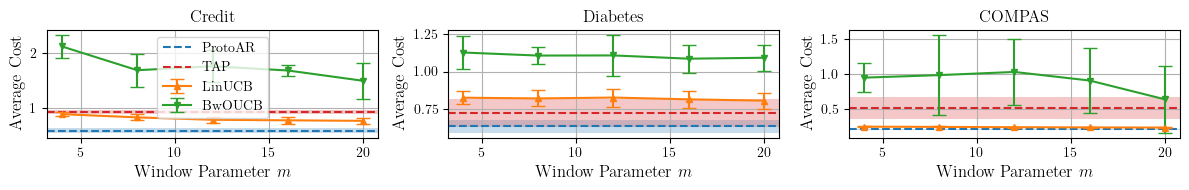

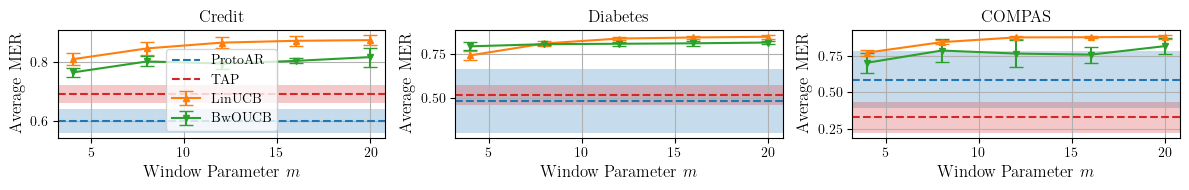

In [16]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/05_timeout_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    errorbar_result(results, key='improvement', xlabel=r'Window Parameter $m$', line_method=['ProtoAR', 'TAP'])
    plt.savefig('./fig/appendix/05_timeout_improvement_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/05_timeout_improvement_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='cost', xlabel=r'Window Parameter $m$', line_method=['ProtoAR', 'TAP'])
    plt.savefig('./fig/appendix/05_timeout_cost_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/05_timeout_cost_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='mean_expected_reward', xlabel=r'Window Parameter $m$', line_method=['ProtoAR', 'TAP'])
    plt.savefig('./fig/appendix/05_timeout_reward_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/05_timeout_reward_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)


## 06. Sensitivity Analysis (LinUCB)

In [17]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_sensitivity_of_linucb(dataset)

with open('./res/appendix/06_sensitivity_of_linucb_without_noise_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_sensitivity_of_linucb(dataset, probability_noise=0.25)

with open('./res/appendix/06_sensitivity_of_linucb_with_noise_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_sensitivity_of_linucb(dataset, estimator=MLPClassifier(max_iter=5000))

with open('./res/appendix/06_sensitivity_of_linucb_without_noise_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_sensitivity_of_linucb(dataset, estimator=MLPClassifier(max_iter=5000), probability_noise=0.25)

with open('./res/appendix/06_sensitivity_of_linucb_with_noise_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


Diabetes


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


COMPAS


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Credit


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Diabetes


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


COMPAS


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Credit


100%|██████████| 5/5 [00:34<00:00,  6.95s/it]


Diabetes


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


COMPAS


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Credit


100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


Diabetes


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


COMPAS


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


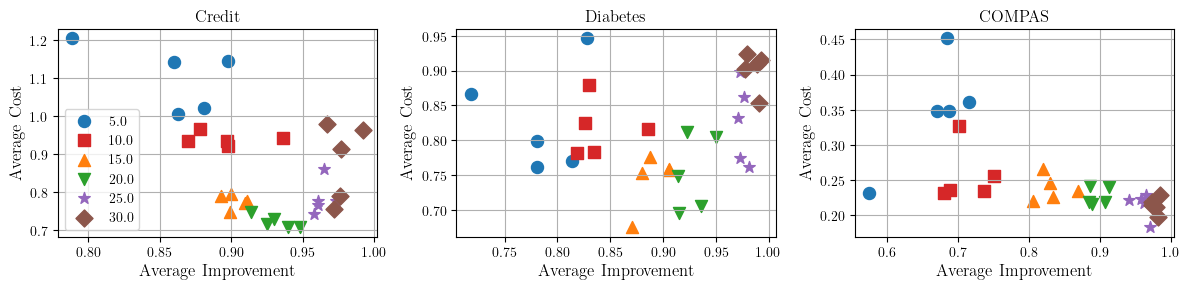

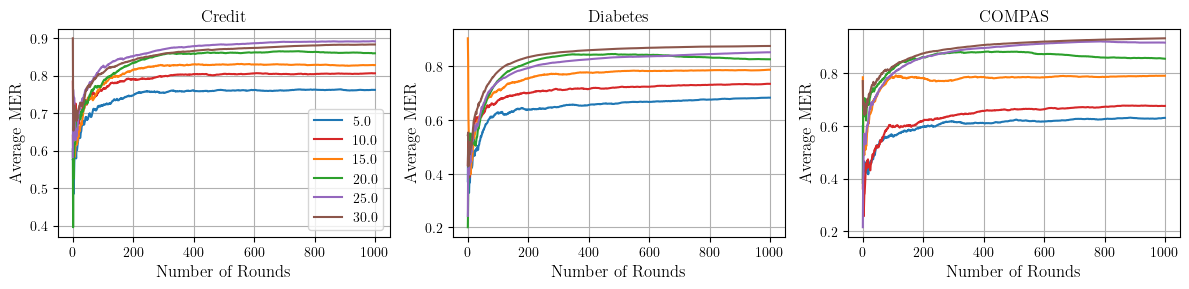

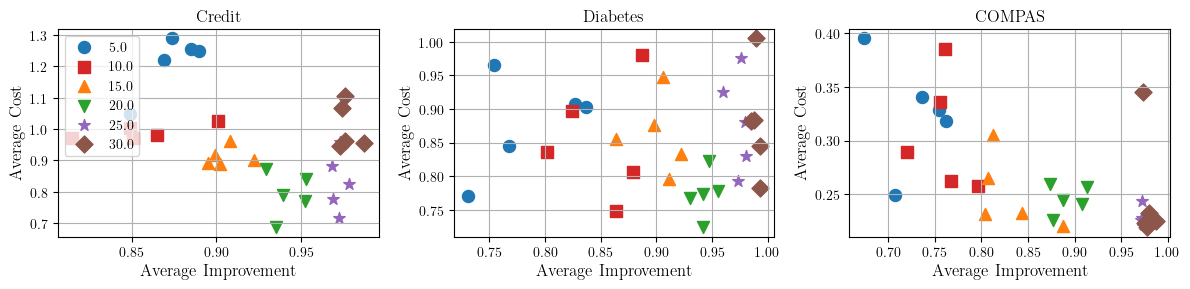

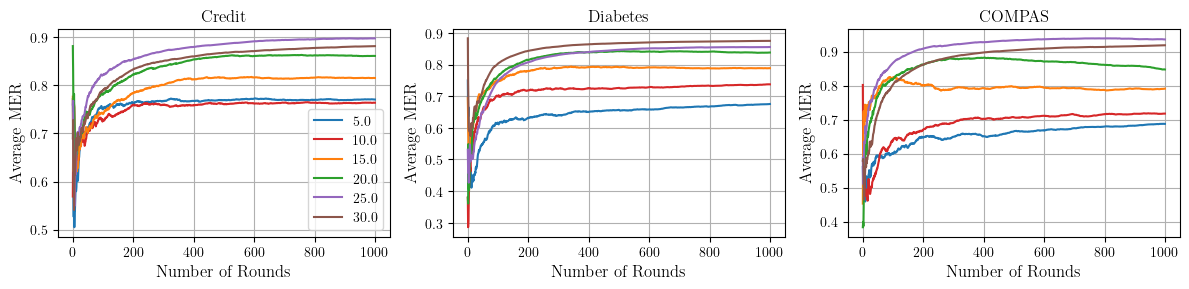

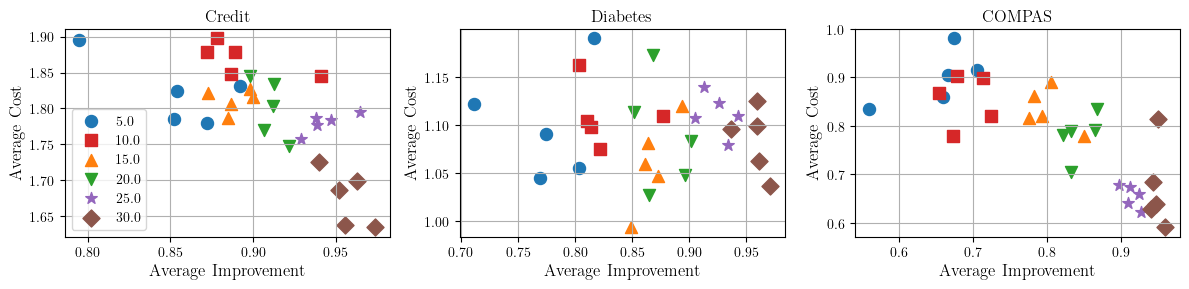

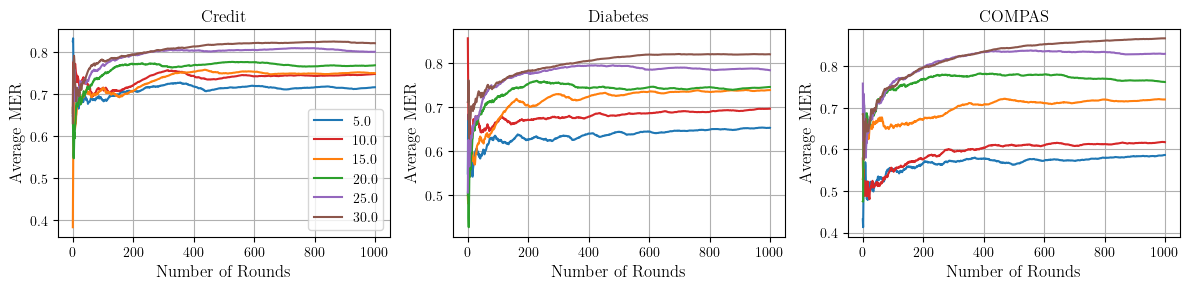

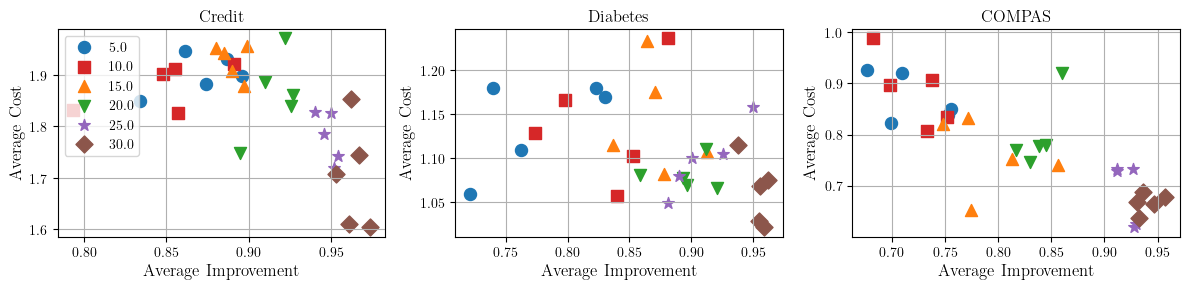

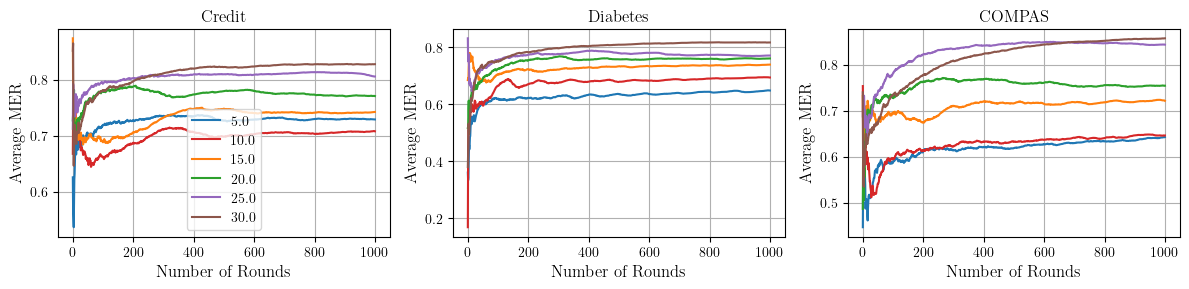

In [18]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/06_sensitivity_of_linucb_without_noise_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost')
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_without_noise_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_without_noise_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward')
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_without_noise_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_without_noise_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)
    

for clf in ['rf', 'mlp']:

    with open('./res/appendix/06_sensitivity_of_linucb_with_noise_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost')
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_with_noise_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_with_noise_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward')
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_with_noise_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/06_sensitivity_of_linucb_with_noise_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

## 07. Sensitivity Analysis (BwOUCB)

In [19]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_sensitivity_of_bwoucb(dataset)

with open('./res/appendix/07_sensitivity_of_bwoucb_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_sensitivity_of_bwoucb(dataset, estimator=MLPClassifier(max_iter=5000))

with open('./res/appendix/07_sensitivity_of_bwoucb_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 5/5 [03:01<00:00, 36.38s/it]


Diabetes


100%|██████████| 5/5 [02:55<00:00, 35.04s/it]


COMPAS


100%|██████████| 5/5 [02:50<00:00, 34.07s/it]


Credit


100%|██████████| 5/5 [03:32<00:00, 42.58s/it]


Diabetes


100%|██████████| 5/5 [02:33<00:00, 30.61s/it]


COMPAS


100%|██████████| 5/5 [02:54<00:00, 34.92s/it]


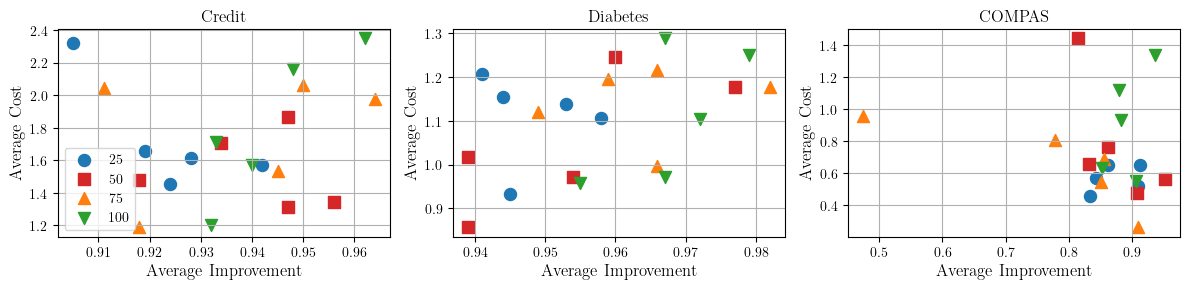

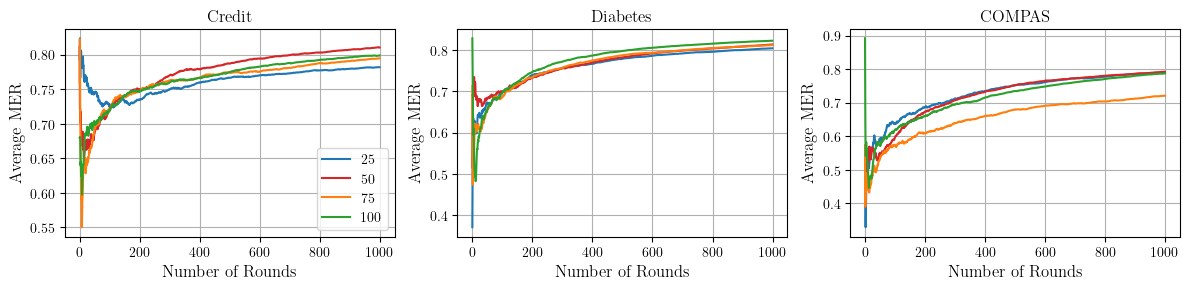

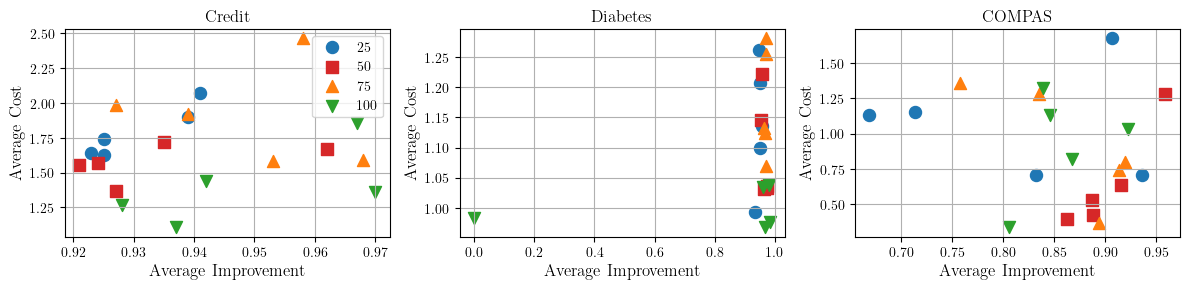

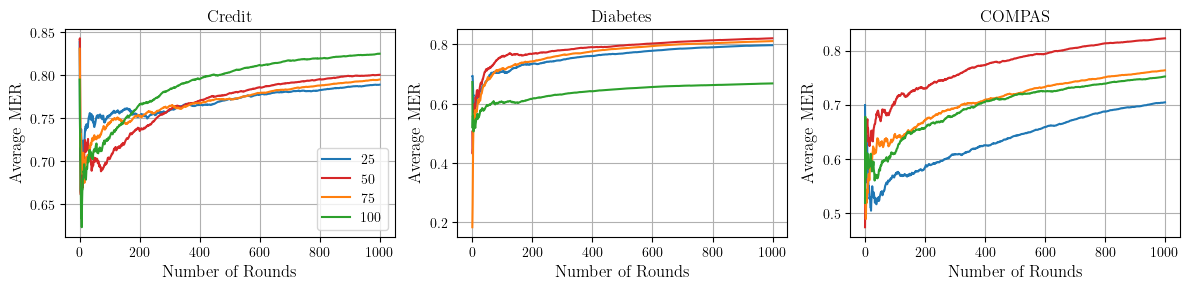

In [20]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/07_sensitivity_of_bwoucb_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost')
    plt.savefig('./fig/appendix/07_sensitivity_of_bwoucb_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/07_sensitivity_of_bwoucb_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward')
    plt.savefig('./fig/appendix/07_sensitivity_of_bwoucb_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/07_sensitivity_of_bwoucb_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

## 08. Comparison to GP-based Algorithm

In [21]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, methods=['ProtoAR', 'TAP', 'LinUCB', 'BwOUCB', 'CGPUCB'])

with open('./res/appendix/08_comparison_to_cgpucb_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, methods=['ProtoAR', 'TAP', 'LinUCB', 'BwOUCB', 'CGPUCB'], estimator=MLPClassifier(max_iter=5000))

with open('./res/appendix/08_comparison_to_cgpucb_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 5/5 [6:23:09<00:00, 4597.96s/it]  


Diabetes


100%|██████████| 5/5 [6:54:07<00:00, 4969.57s/it]  


COMPAS


100%|██████████| 5/5 [6:49:14<00:00, 4910.88s/it]  


Credit


100%|██████████| 5/5 [6:38:16<00:00, 4779.24s/it]  


Diabetes


100%|██████████| 5/5 [6:43:15<00:00, 4839.08s/it]  


COMPAS


100%|██████████| 5/5 [7:05:05<00:00, 5101.14s/it]  


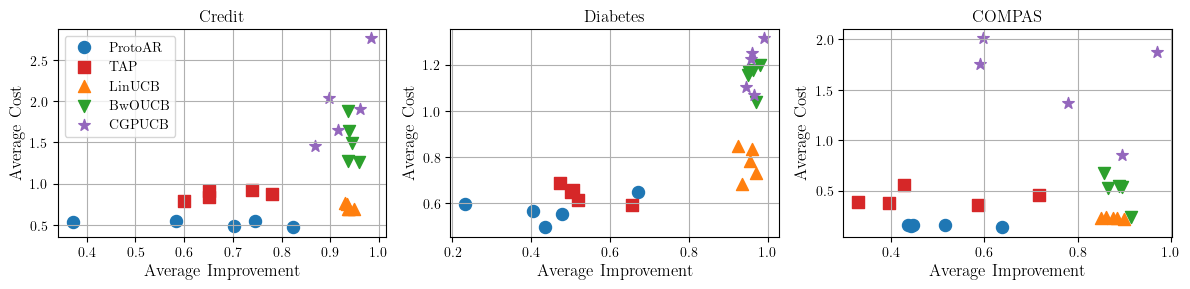

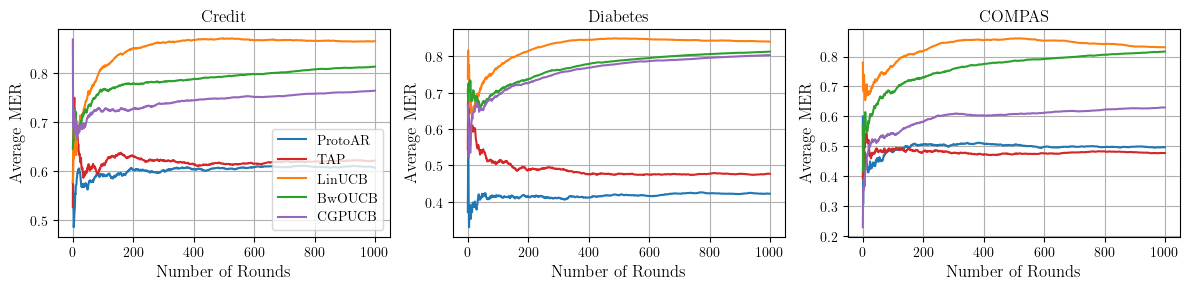

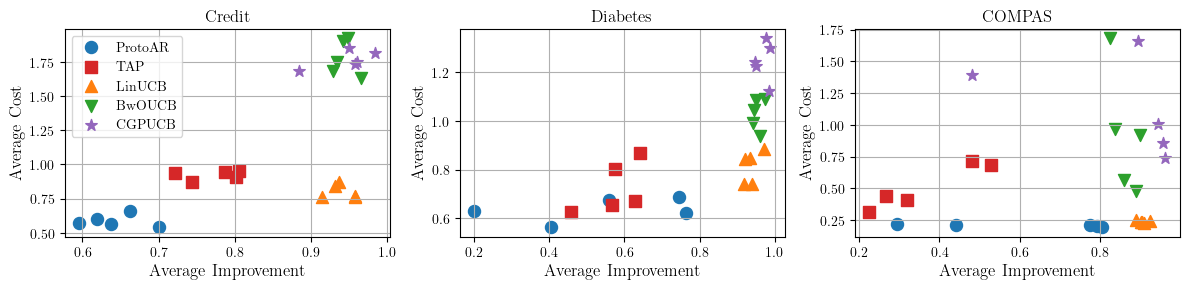

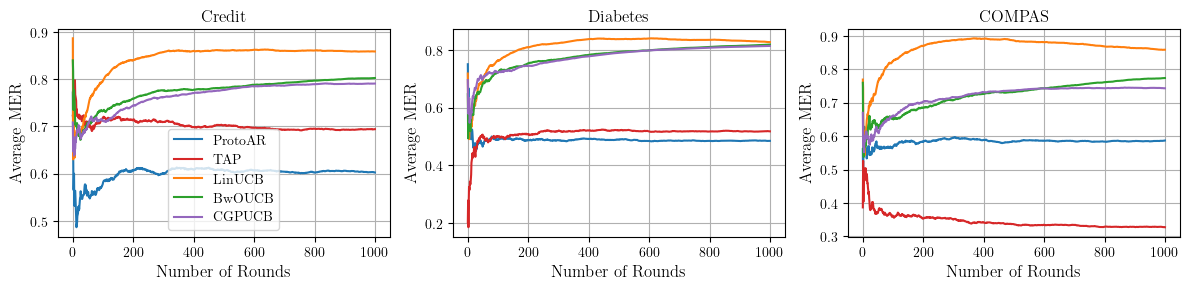

In [22]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/08_comparison_to_cgpucb_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost')
    plt.savefig('./fig/appendix/08_comparison_to_cgpucb_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/08_comparison_to_cgpucb_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward')
    plt.savefig('./fig/appendix/08_comparison_to_cgpucb_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/08_comparison_to_cgpucb_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

In [23]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/08_comparison_to_cgpucb_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)

    print(clf)
    latex_result(results, key='time')

rf
\toprule
\textbf{Dataset} & \textbf{ProtoAR} & \textbf{TAP} & \textbf{LinUCB} & \textbf{BwOUCB} & \textbf{CGPUCB} \\
\midrule
Credit & $0.000511 \pm 0.0002$ & $0.000466 \pm 0.0001$ & $0.00102 \pm 0.0024$ & $0.018433 \pm 0.0129$ & $4.596519 \pm 3.4732$ \\
Diabetes & $0.000449 \pm 0.0002$ & $0.000402 \pm 0.0$ & $0.000842 \pm 0.003$ & $0.018078 \pm 0.0126$ & $4.969328 \pm 3.9377$ \\
COMPAS & $0.000449 \pm 0.0006$ & $0.000387 \pm 0.0001$ & $0.000878 \pm 0.0028$ & $0.01813 \pm 0.0126$ & $4.910568 \pm 3.8431$ \\
\bottomrule

mlp
\toprule
\textbf{Dataset} & \textbf{ProtoAR} & \textbf{TAP} & \textbf{LinUCB} & \textbf{BwOUCB} & \textbf{CGPUCB} \\
\midrule
Credit & $0.000513 \pm 0.0002$ & $0.000538 \pm 0.0002$ & $0.000981 \pm 0.0031$ & $0.017839 \pm 0.0128$ & $4.773834 \pm 3.7382$ \\
Diabetes & $0.000464 \pm 0.0005$ & $0.000458 \pm 0.0002$ & $0.000889 \pm 0.0026$ & $0.018658 \pm 0.0132$ & $4.837761 \pm 3.5966$ \\
COMPAS & $0.000454 \pm 0.0002$ & $0.000377 \pm 0.0002$ & $0.000928 \pm 0.0028$ &

## 09. Model-Update Scenario

In [24]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for model_update in [25, 50, 75, 100]:
        results[dataset.name][model_update] = run_comparison(dataset, model_update=model_update)

with open('./res/appendix/09_model_update_rf.pkl', 'wb') as f: 
    pickle.dump(results, f)
    
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for model_update in [25, 50, 75, 100]:
        results[dataset.name][model_update] = run_comparison(dataset, estimator=MLPClassifier(max_iter=5000), model_update=model_update)

with open('./res/appendix/09_model_update_mlp.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 5/5 [02:20<00:00, 28.09s/it]


Diabetes


100%|██████████| 5/5 [01:32<00:00, 18.60s/it]


COMPAS


100%|██████████| 5/5 [01:35<00:00, 19.19s/it]


Credit


100%|██████████| 5/5 [07:26<00:00, 89.38s/it]


Diabetes


100%|██████████| 5/5 [02:51<00:00, 34.29s/it]


COMPAS


100%|██████████| 5/5 [02:48<00:00, 33.62s/it]


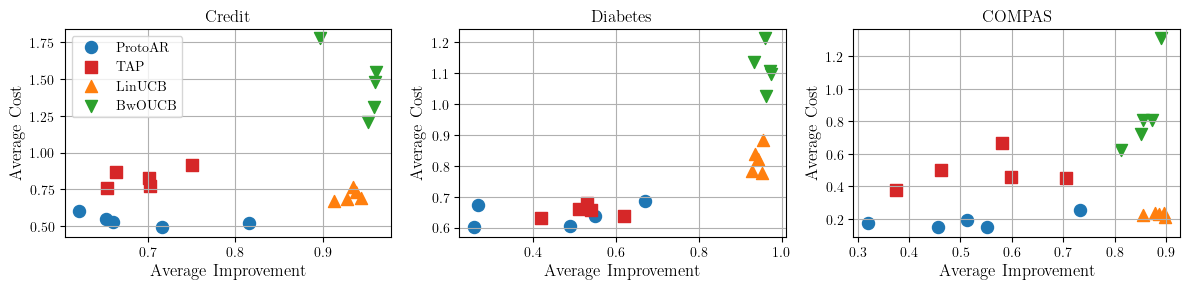

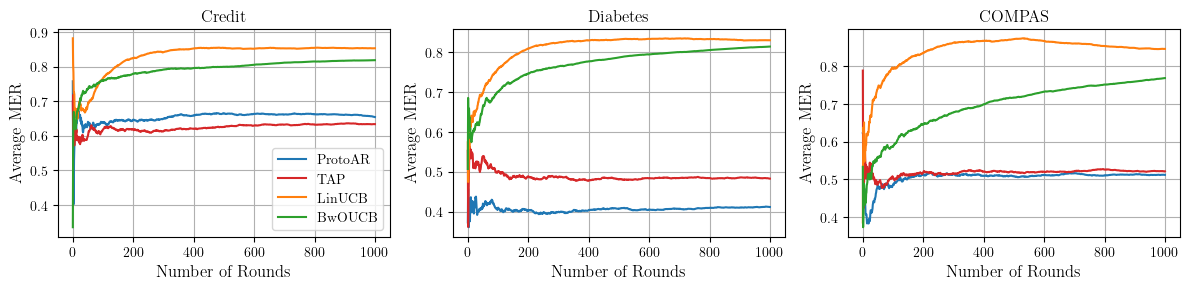

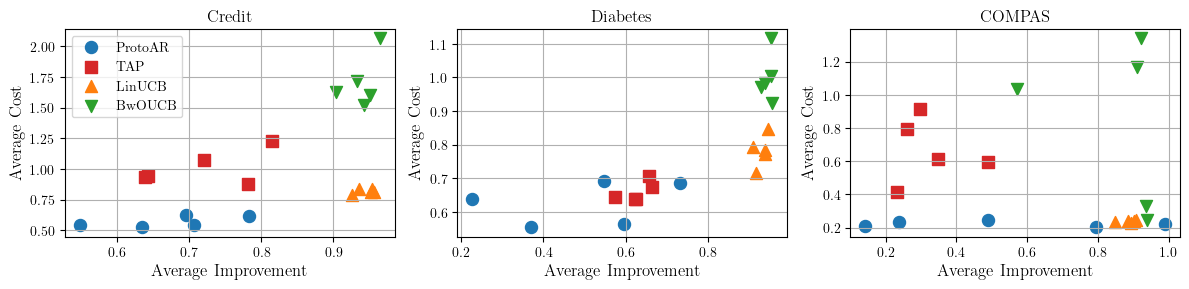

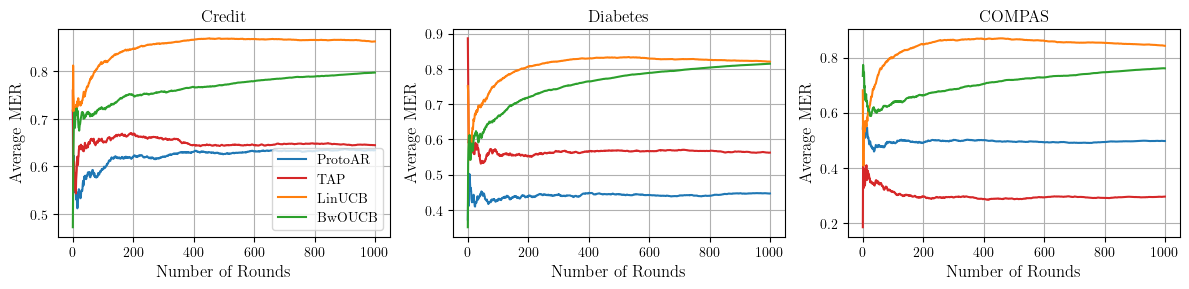

In [25]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/09_model_update_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    scatter_results(results, key1='improvement', key2='cost', key_=25)
    plt.savefig('./fig/appendix/09_model_update_scatter_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/09_model_update_scatter_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    plot_results(results, key='mean_expected_reward', key_=25)
    plt.savefig('./fig/appendix/09_model_update_plot_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/09_model_update_plot_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

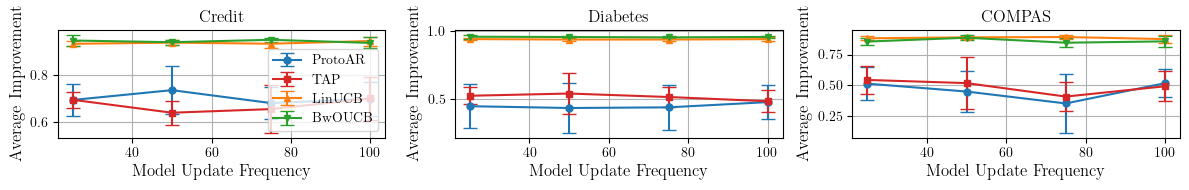

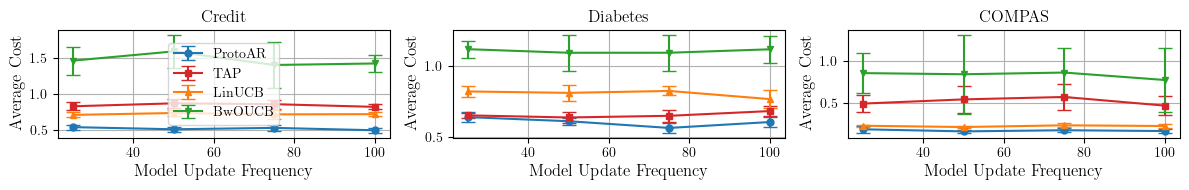

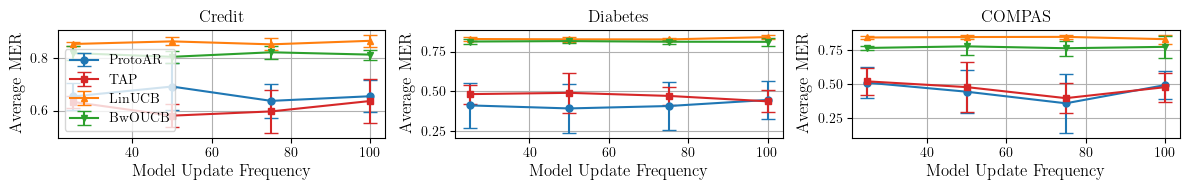

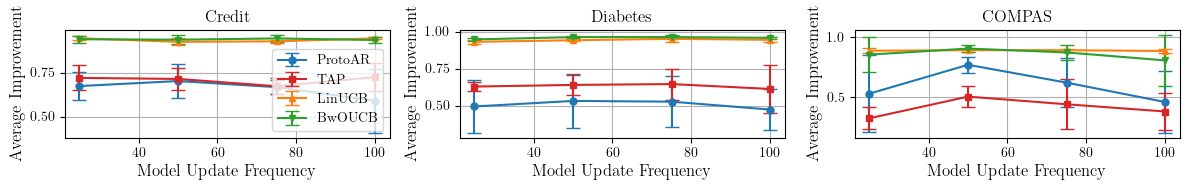

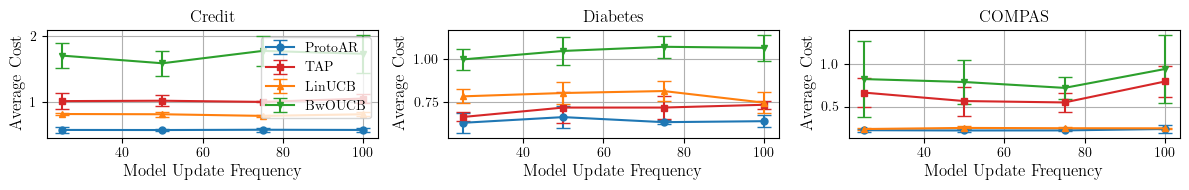

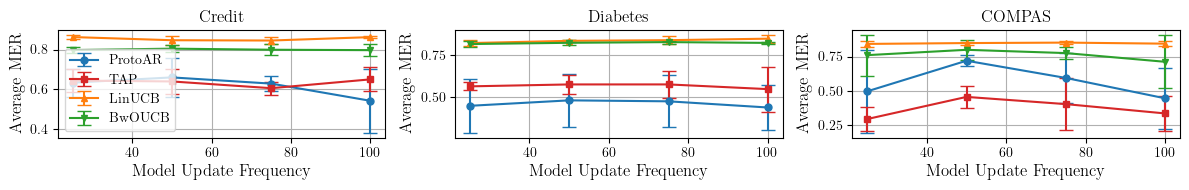

In [26]:
for clf in ['rf', 'mlp']:

    with open('./res/appendix/09_model_update_{}.pkl'.format(clf), 'rb') as f:
        results = pickle.load(f)
        
    errorbar_result(results, key='improvement', xlabel='Model Update Frequency')
    plt.savefig('./fig/appendix/09_model_update_improvement_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/09_model_update_improvement_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='cost', xlabel='Model Update Frequency')
    plt.savefig('./fig/appendix/09_model_update_cost_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/09_model_update_cost_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)

    errorbar_result(results, key='mean_expected_reward', xlabel='Model Update Frequency')
    plt.savefig('./fig/appendix/09_model_update_reward_{}.png'.format(clf), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/appendix/09_model_update_reward_{}.pdf'.format(clf), bbox_inches='tight', pad_inches=0.05)
